In [6]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
from copy import deepcopy
from utils import *
import seaborn as sns

torch.manual_seed(12345)
print(torch.__version__, torchvision.__version__)

%load_ext autoreload
%autoreload 2

2.3.1+cpu 0.18.1+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified
Running on cpu


In [8]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

## Good seed with faster convergence

In [9]:
model = torch.load("model.pth")
net = LeNet().to(device)
net.load_state_dict(model)

<All keys matched successfully>

GT label is 84. 
Onehot label is 84.


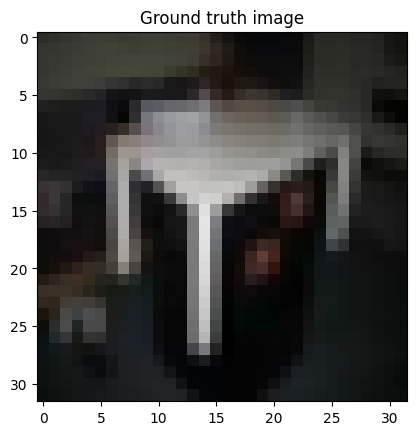

In [10]:
######### honest partipant #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)

# gt_data = tp(Image.open('me.jpg')).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx_ = torch.autograd.grad(y, net.parameters())

import torch.quantization as quant

# Quantize the gradients
quantized_dy_dx = []
for grad in dy_dx_:
    quantized_grad = add_sparsity(grad)
    quantized_dy_dx.append(quantized_grad)

dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

# share the quantized gradients with other clients
original_quantized_dy_dx = list((_.detach().clone() for _ in quantized_dy_dx))

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [11]:
type(dy_dx), len(dy_dx), type(dy_dx[0]), dy_dx[0].size(), original_dy_dx[0].size()

(list, 10, torch.Tensor, torch.Size([12, 3, 5, 5]), torch.Size([12, 3, 5, 5]))

Dummy label is 7.


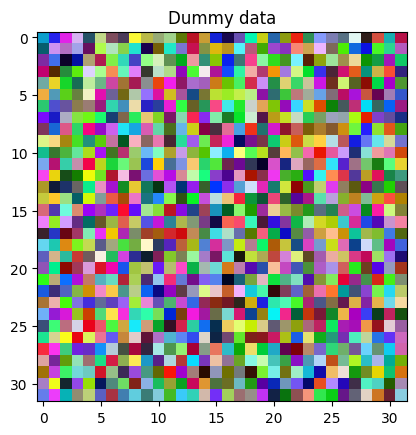

In [12]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [13]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000
        grad_diff.backward()

        return grad_diff

    optimizer.step(closure)
    if iters % 10 == 0:
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
    history.append(tt(dummy_data[0].cpu()))

0 83.4571
10 1.6845
20 0.4643
30 0.2862
40 0.2560
50 0.2505
60 0.2488
70 0.2483
80 0.2481
90 0.2480
100 0.2479
110 0.2479
120 0.2479
130 0.2479
140 0.2479
150 0.2479
160 0.2479
170 0.2479
180 0.2479
190 0.2479
200 0.2479
210 0.2479
220 0.2479
230 0.2479
240 0.2479
250 0.2479
260 0.2479
270 0.2479
280 0.2479
290 0.2479


## L1 loss over the iterations

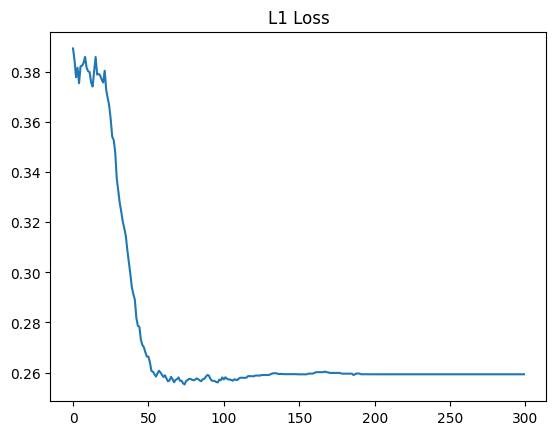

In [14]:
import torch

import torchvision.transforms as transforms

# Convert history images to tensors

history_tensors = [tp(img) for img in history]

# Convert ground truth image to tensor
gt_tensor = gt_data[0]

# Calculate L2 loss
l2_losses = []
for img_tensor in history_tensors:
    l2_losses.append(torch.nn.L1Loss()(img_tensor, gt_tensor).item())

# Print the total L2 loss
sns.lineplot(x=range(len(l2_losses)), y=l2_losses)
plt.title("L1 Loss")
plt.show()

## Reconstructed images

Dummy label is 84.


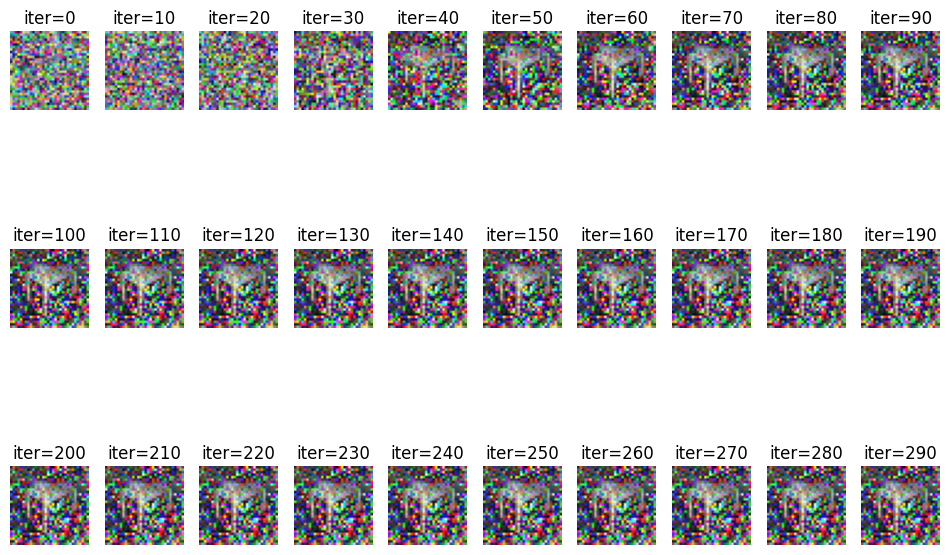

In [15]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())